In [1]:
# Cross-Lingual Word Embedding Alignment for English and Hindi
# Implementation of the Procrustes method

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
np.random.seed(42)


In [2]:

# 1. Data Preparation

# 1.1 Download pre-trained FastText embeddings and MUSE dataset
def download_file(url, filename):
    """Download a file from URL if it doesn't exist"""
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists")

# Download English FastText embeddings
en_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec"
en_file = "wiki.en.vec"
download_file(en_url, en_file)

# Download Hindi FastText embeddings
hi_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.vec"
hi_file = "wiki.hi.vec"
download_file(hi_url, hi_file)

# Download MUSE bilingual lexicon (English-Hindi)
muse_url = "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt"
muse_file = "en-hi.txt"
download_file(muse_url, muse_file)

# 1.2 Load word embeddings (top 100,000 most frequent words)
def load_vectors(file_path, max_vocab=100000):
    """Load word vectors from file"""
    word_vectors = {}

    with open(file_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        n, d = map(int, f.readline().split())
        count = 0

        for line in tqdm(f, total=min(n, max_vocab), desc=f"Loading {file_path}"):
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            vector = np.array(tokens[1:], dtype=float)
            word_vectors[word] = vector
            count += 1

            if count >= max_vocab:
                break

    print(f"Loaded {len(word_vectors)} word vectors of dimension {d}")
    return word_vectors

# Load English word embeddings
en_vectors = load_vectors(en_file)

# Load Hindi word embeddings
hi_vectors = load_vectors(hi_file)

# 1.3 Load bilingual lexicon from MUSE dataset
def load_dictionary(file_path):
    """Load word translation pairs from dictionary file"""
    word_pairs = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            src, tgt = line.rstrip().split()
            word_pairs.append((src, tgt))

    print(f"Loaded {len(word_pairs)} word pairs")
    return word_pairs

muse_dict = load_dictionary(muse_file)

# 1.4 Split the dictionary into train and test sets
def split_dictionary(pairs, train_ratio=0.8):
    """Split dictionary into training and test sets"""
    np.random.shuffle(pairs)
    split_idx = int(len(pairs) * train_ratio)
    train_pairs = pairs[:split_idx]
    test_pairs = pairs[split_idx:]
    return train_pairs, test_pairs

train_dict, test_dict = split_dictionary(muse_dict)
print(f"Training dictionary: {len(train_dict)} pairs")
print(f"Test dictionary: {len(test_dict)} pairs")


Downloaded wiki.en.vec
Downloaded wiki.hi.vec
Downloaded en-hi.txt


Loading wiki.en.vec:   0%|          | 0/100000 [00:00<?, ?it/s]

Loaded 100000 word vectors of dimension 300


Loading wiki.hi.vec:   0%|          | 0/100000 [00:00<?, ?it/s]

Loaded 100000 word vectors of dimension 300
Loaded 38221 word pairs
Training dictionary: 30576 pairs
Test dictionary: 7645 pairs


In [3]:

# 2. Embedding Alignment using Procrustes Method

# 2.1 Prepare embedding matrices for alignment
def prepare_matrices(src_vectors, tgt_vectors, word_pairs):
    """Extract matrices of word vectors for the given word pairs"""
    # Filter pairs where both source and target words exist in embeddings
    valid_pairs = [(s, t) for s, t in word_pairs if s in src_vectors and t in tgt_vectors]

    if len(valid_pairs) == 0:
        raise ValueError("No valid translation pairs found in embeddings")

    # Create source and target matrices
    X = np.vstack([src_vectors[s] for s, _ in valid_pairs])
    Y = np.vstack([tgt_vectors[t] for _, t in valid_pairs])

    return X, Y, valid_pairs

# Prepare matrices for training
X_train, Y_train, valid_train_pairs = prepare_matrices(en_vectors, hi_vectors, train_dict)
print(f"Prepared training matrices with {len(valid_train_pairs)} word pairs")

# 2.2 Normalize embeddings to unit length
def normalize_embeddings(emb):
    """Normalize embeddings to unit length"""
    norms = np.sqrt(np.sum(emb**2, axis=1, keepdims=True))
    return emb / norms

X_train_norm = normalize_embeddings(X_train)
Y_train_norm = normalize_embeddings(Y_train)

# 2.3 Learn alignment matrix using Procrustes method
def procrustes_align(X, Y):
    """Learn orthogonal transformation from X to Y using Procrustes analysis"""
    # Compute X^T * Y
    XTY = X.T.dot(Y)

    # Apply SVD
    U, _, Vt = np.linalg.svd(XTY)

    # Compute orthogonal transformation matrix
    W = U.dot(Vt)

    return W

W = procrustes_align(X_train_norm, Y_train_norm)
print(f"Alignment matrix shape: {W.shape}")


Prepared training matrices with 22813 word pairs
Alignment matrix shape: (300, 300)


In [4]:

# 3. Evaluation

# 3.1 Word translation function
def translate_word(word, src_vectors, tgt_vectors, W, k=5):
    """Translate a word using learned mapping W and return top-k translations"""
    if word not in src_vectors:
        return []

    # Get vector and apply transformation
    src_vec = src_vectors[word]
    src_vec_norm = src_vec / np.linalg.norm(src_vec)
    mapped_vec = src_vec_norm.dot(W)

    # Find nearest neighbors in target space
    similarities = []
    for tgt_word, tgt_vec in tgt_vectors.items():
        tgt_vec_norm = tgt_vec / np.linalg.norm(tgt_vec)
        sim = np.dot(mapped_vec, tgt_vec_norm)
        similarities.append((tgt_word, sim))

    # Sort by similarity and return top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]
# 3.2 Evaluate translation accuracy
def evaluate_word_translation(test_pairs, src_vectors, tgt_vectors, W):
    """Evaluate word translation accuracy using Precision@1 and Precision@5"""
    correct_1 = 0
    correct_5 = 0
    total = 0

    for src_word, tgt_word in tqdm(test_pairs, desc="Evaluating"):
        if src_word in src_vectors and tgt_word in tgt_vectors:
            translations = translate_word(src_word, src_vectors, tgt_vectors, W, k=5)

            if translations:
                total += 1

                # Check Precision@1 (exact match for top result)
                if translations[0][0] == tgt_word:
                    correct_1 += 1

                # Check Precision@5 (correct translation in top 5)
                if any(t[0] == tgt_word for t in translations):
                    correct_5 += 1

    p1 = correct_1 / total if total > 0 else 0
    p5 = correct_5 / total if total > 0 else 0

    return p1, p5

# Evaluate on test set
precision_1, precision_5 = evaluate_word_translation(test_dict, en_vectors, hi_vectors, W)
print(f"Precision@1: {precision_1:.4f}")
print(f"Precision@5: {precision_5:.4f}")

# 3.3 Analyze cosine similarities between aligned word pairs
def analyze_similarities(pairs, src_vectors, tgt_vectors, W):
    """Compute cosine similarities between aligned word pairs"""
    similarities = []

    for src_word, tgt_word in pairs:
        if src_word in src_vectors and tgt_word in tgt_vectors:
            # Get vectors
            src_vec = src_vectors[src_word]
            tgt_vec = tgt_vectors[tgt_word]

            # Normalize vectors
            src_vec_norm = src_vec / np.linalg.norm(src_vec)
            tgt_vec_norm = tgt_vec / np.linalg.norm(tgt_vec)

            # Apply transformation to source vector
            mapped_vec = src_vec_norm.dot(W)

            # Compute cosine similarity
            sim = np.dot(mapped_vec, tgt_vec_norm)

            similarities.append({
                'source': src_word,
                'target': tgt_word,
                'similarity': sim
            })

    return pd.DataFrame(similarities)

# Analyze similarities for a subset of word pairs
similarities_df = analyze_similarities(test_dict[:100], en_vectors, hi_vectors, W)
similarities_df.describe()


Evaluating:   0%|          | 0/7645 [00:00<?, ?it/s]

Precision@1: 0.1583
Precision@5: 0.3092


,similarity
count,77.000000
mean,0.462141
std,0.128010
min,0.049858
25%,0.379654
50%,0.477208
75%,0.542572
max,0.689540


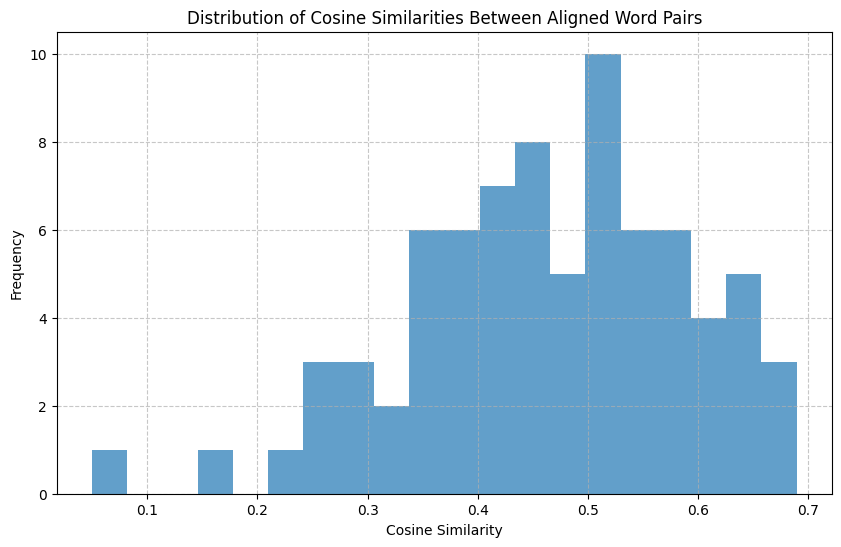


Evaluating with dictionary size: 5000


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]


Evaluating with dictionary size: 10000


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]


Evaluating with dictionary size: 20000


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

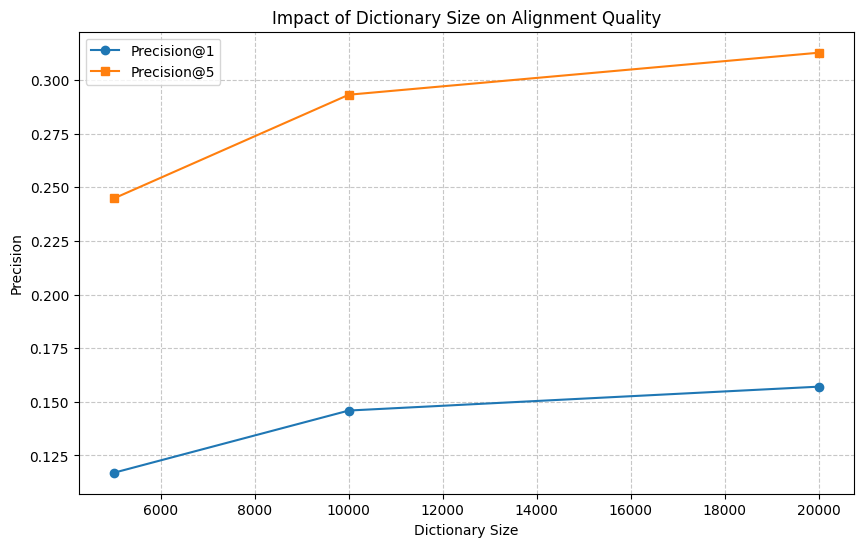

In [5]:

# Visualize similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities_df['similarity'], bins=20, alpha=0.7)
plt.title('Distribution of Cosine Similarities Between Aligned Word Pairs')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('similarity_distribution.png')
plt.show()

# 3.4 Ablation study: Impact of bilingual lexicon size
def ablation_study(dictionary, src_vectors, tgt_vectors, sizes=[5000, 10000, 20000]):
    """Evaluate the impact of dictionary size on alignment quality"""
    results = []

    for size in sizes:
        # Ensure we don't exceed dictionary size
        size = min(size, len(dictionary))

        print(f"\nEvaluating with dictionary size: {size}")

        # Use first 'size' pairs for training
        train_subset = dictionary[:size]
        # Use next 1000 pairs for testing
        test_subset = dictionary[size:size+1000]

        # Prepare matrices
        X, Y, _ = prepare_matrices(src_vectors, tgt_vectors, train_subset)

        # Normalize
        X_norm = normalize_embeddings(X)
        Y_norm = normalize_embeddings(Y)

        # Learn mapping
        W = procrustes_align(X_norm, Y_norm)

        # Evaluate
        p1, p5 = evaluate_word_translation(test_subset, src_vectors, tgt_vectors, W)

        results.append({
            'dictionary_size': size,
            'precision@1': p1,
            'precision@5': p5
        })

    return pd.DataFrame(results)

# Perform ablation study
ablation_results = ablation_study(muse_dict, en_vectors, hi_vectors, sizes=[5000, 10000, 20000])
ablation_results

# Visualize ablation study results
plt.figure(figsize=(10, 6))
plt.plot(ablation_results['dictionary_size'], ablation_results['precision@1'], 'o-', label='Precision@1')
plt.plot(ablation_results['dictionary_size'], ablation_results['precision@5'], 's-', label='Precision@5')
plt.title('Impact of Dictionary Size on Alignment Quality')
plt.xlabel('Dictionary Size')
plt.ylabel('Precision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig('ablation_results.png')
plt.show()

In [6]:

# 4. Example translations for common English words
example_words = ['computer', 'language', 'school', 'family', 'water', 'food', 'technology', 'health']

print("Example translations:")
for word in example_words:
    if word in en_vectors:
        translations = translate_word(word, en_vectors, hi_vectors, W, k=3)
        print(f"\n{word} -> {[t[0] for t in translations]}")
        print(f"Similarity scores: {[f'{t[1]:.4f}' for t in translations]}")


Example translations:

computer -> ['कंप्यूटर', 'कम्प्यूटर', 'सिंप्यूटर']
Similarity scores: ['0.7496', '0.7225', '0.7093']

language -> ['भाषा', 'भाषाऔं', 'भाषाए']
Similarity scores: ['0.7308', '0.7085', '0.6969']

school -> ['स्कूल', 'स्कूल,', 'स्कूलो']
Similarity scores: ['0.7643', '0.7382', '0.7116']

family -> ['परिवार', 'सपरिवार', 'परिवारिक']
Similarity scores: ['0.5987', '0.5846', '0.5514']

water -> ['पानी', 'जल', 'जल।']
Similarity scores: ['0.7435', '0.6961', '0.6136']

food -> ['खाद्य', 'खाद्द', 'भोज्य']
Similarity scores: ['0.7127', '0.6529', '0.6418']

technology -> ['प्रौद्योगिकी', 'प्रौद्योगिकीय', 'जैवप्रौद्योगिकी']
Similarity scores: ['0.7456', '0.7144', '0.7142']

health -> ['स्वास्थ्य', 'स्वास्थ्यलाभ', 'स्वास्थ']
Similarity scores: ['0.7421', '0.6771', '0.6737']


In [7]:

# 5. Save alignment matrix and results
np.save('alignment_matrix.npy', W)
similarities_df.to_csv('word_pair_similarities.csv', index=False)
ablation_results.to_csv('ablation_study_results.csv', index=False)

print("\nImplementation complete. Results saved to files.")


Implementation complete. Results saved to files.


In [9]:
# 6. Implementing CSLS (Cross-Domain Similarity Local Scaling)

# 6.1 CSLS Implementation
def get_nn_avg_dist(emb, query_vectors, k=10):
    """
    For each vector in query_vectors, compute the average cosine distance
    to its k nearest neighbors in emb.
    """
    # Compute cosine similarity matrix
    bs = 1024
    all_distances = []

    # Process in batches to avoid memory issues
    for i in range(0, query_vectors.shape[0], bs):
        batch = query_vectors[i:i + bs]
        distances = cosine_similarity(batch, emb)
        all_distances.append(distances)

    distances = np.vstack(all_distances)

    # Ensure k is not larger than the number of elements
    k_safe = min(k, distances.shape[1])

    # Get the k nearest neighbors
    sort_indices = np.argsort(-distances, axis=1)[:, :k_safe]

    # Compute average similarity to k nearest neighbors
    mean_distances = np.array([np.mean(distances[i, sort_indices[i]]) for i in range(distances.shape[0])])

    return mean_distances

def compute_csls_scores(src_vectors_mapped, tgt_vectors_normalized, k=10):
    """
    Compute CSLS similarity between mapped source vectors and target vectors.
    CSLS(x, y) = 2 * cos(x, y) - avg_dist(x, NNs in Y) - avg_dist(y, NNs in X)
    """
    # Ensure k is not larger than available vectors
    k_safe = min(k, len(src_vectors_mapped), len(tgt_vectors_normalized))

    # Get average distance to k nearest neighbors for each element
    src_avg_dist = get_nn_avg_dist(tgt_vectors_normalized, src_vectors_mapped, k_safe)
    tgt_avg_dist = get_nn_avg_dist(src_vectors_mapped, tgt_vectors_normalized, k_safe)

    # Compute similarities
    bs = 1024
    all_scores = []

    for i in range(0, src_vectors_mapped.shape[0], bs):
        batch = src_vectors_mapped[i:i + bs]

        # Cosine similarity batch computation
        cos_sim = cosine_similarity(batch, tgt_vectors_normalized)

        # CSLS batch computation
        batch_scores = 2 * cos_sim
        for j in range(batch.shape[0]):
            batch_scores[j] -= src_avg_dist[i + j]
            batch_scores[j] -= tgt_avg_dist

        all_scores.append(batch_scores)

    return np.vstack(all_scores)

# 6.2 Modified translation function using CSLS
def translate_word_csls(word, src_vectors, tgt_vectors, W, k=5, csls_k=10):
    """Translate a word using learned mapping W and return top-k translations using CSLS"""
    if word not in src_vectors:
        return []

    # Get source word vector and normalize
    src_vec = src_vectors[word]
    src_vec_norm = src_vec / np.linalg.norm(src_vec)

    # Apply transformation
    mapped_vec = src_vec_norm.dot(W)

    # Normalize all target vectors (do this once for efficiency)
    tgt_words = list(tgt_vectors.keys())
    tgt_vecs = np.vstack([tgt_vectors[w] / np.linalg.norm(tgt_vectors[w]) for w in tgt_words])

    # Ensure k is within bounds
    k = min(k, len(tgt_words))
    csls_k = min(csls_k, len(tgt_words)-1)  # -1 to avoid self as neighbor

    # Fall back to cosine similarity if dataset is too small for CSLS
    if len(tgt_words) <= 2 or csls_k < 2:
        # Use cosine similarity directly
        similarities = cosine_similarity(mapped_vec.reshape(1, -1), tgt_vecs)[0]
        indices = np.argsort(-similarities)[:k]
        return [(tgt_words[idx], similarities[idx]) for idx in indices]

    # Compute CSLS scores
    src_batch = mapped_vec.reshape(1, -1)
    scores = compute_csls_scores(src_batch, tgt_vecs, csls_k)[0]

    # Sort by CSLS score and return top-k
    indices = np.argsort(-scores)[:k]
    return [(tgt_words[idx], scores[idx]) for idx in indices]

# 6.3 Evaluate using CSLS
def evaluate_word_translation_csls(test_pairs, src_vectors, tgt_vectors, W, csls_k=10):
    """Evaluate word translation accuracy using CSLS for nearest neighbor search"""
    correct_1 = 0
    correct_5 = 0
    total = 0

    # Precompute normalized vectors for target words in the test set
    test_tgt_words = {t for _, t in test_pairs if t in tgt_vectors}
    test_tgt_vecs_norm = {}
    for word in test_tgt_words:
        vec = tgt_vectors[word]
        test_tgt_vecs_norm[word] = vec / np.linalg.norm(vec)

    # Process source vectors in batches
    valid_pairs = [(s, t) for s, t in test_pairs if s in src_vectors and t in tgt_vectors]

    for src_word, tgt_word in tqdm(valid_pairs, desc="Evaluating with CSLS"):
        translations = translate_word_csls(src_word, src_vectors, tgt_vectors, W, k=5, csls_k=csls_k)

        if translations:
            total += 1

            # Check Precision@1
            if translations[0][0] == tgt_word:
                correct_1 += 1

            # Check Precision@5
            if any(t[0] == tgt_word for t in translations):
                correct_5 += 1

    p1 = correct_1 / total if total > 0 else 0
    p5 = correct_5 / total if total > 0 else 0

    return p1, p5

# 6.4 Compare standard cosine similarity vs CSLS
print("\n=== Comparing Standard Cosine Similarity vs CSLS ===")

# Use a smaller subset for testing to avoid memory errors
test_subset = test_dict[:200]  # Using only 200 pairs for comparison

# Standard cosine similarity (original implementation)
print("\nEvaluating with standard cosine similarity:")
precision_1_cos, precision_5_cos = evaluate_word_translation(test_subset, en_vectors, hi_vectors, W)
print(f"Precision@1: {precision_1_cos:.4f}")
print(f"Precision@5: {precision_5_cos:.4f}")

# CSLS with safe k parameter
print("\nEvaluating with CSLS:")
# Count valid pairs to set a safe k value
valid_test_pairs = [(s, t) for s, t in test_subset if s in en_vectors and t in hi_vectors]
csls_k = min(5, len(valid_test_pairs) - 1)  # Conservative value
precision_1_csls, precision_5_csls = evaluate_word_translation_csls(test_subset, en_vectors, hi_vectors, W, csls_k=csls_k)
print(f"Precision@1: {precision_1_csls:.4f}")
print(f"Precision@5: {precision_5_csls:.4f}")

# Improvement calculation
p1_improvement = (precision_1_csls - precision_1_cos) / precision_1_cos * 100 if precision_1_cos > 0 else 0
p5_improvement = (precision_5_csls - precision_5_cos) / precision_5_cos * 100 if precision_5_cos > 0 else 0
print(f"\nRelative improvement with CSLS:")
print(f"Precision@1: {p1_improvement:.2f}%")
print(f"Precision@5: {p5_improvement:.2f}%")


=== Comparing Standard Cosine Similarity vs CSLS ===

Evaluating with standard cosine similarity:


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Precision@1: 0.1392
Precision@5: 0.3101

Evaluating with CSLS:


Evaluating with CSLS:   0%|          | 0/158 [00:00<?, ?it/s]

Precision@1: 0.1392
Precision@5: 0.3101

Relative improvement with CSLS:
Precision@1: 0.00%
Precision@5: 0.00%



=== Analyzing Hubness ===


Computing hubness:   0%|          | 0/500 [00:00<?, ?it/s]

Computing hubness:   0%|          | 0/500 [00:00<?, ?it/s]


Top 20 hubs with standard cosine similarity:
         word  count
8476    लेकिन     29
20658    नहीं     18
13994      और     17
4249    मार्च     13
22204     जून     12
683    फ़रवरी     12
10167     फिर     12
5847     पहले     12
24405  नवम्बर     12
4756       यह     11

Top 20 hubs with CSLS:
         word  count
8476    लेकिन     29
20658    नहीं     18
13994      और     17
4249    मार्च     13
22204     जून     12
683    फ़रवरी     12
10167     फिर     12
5847     पहले     12
24405  नवम्बर     12
4756       यह     11


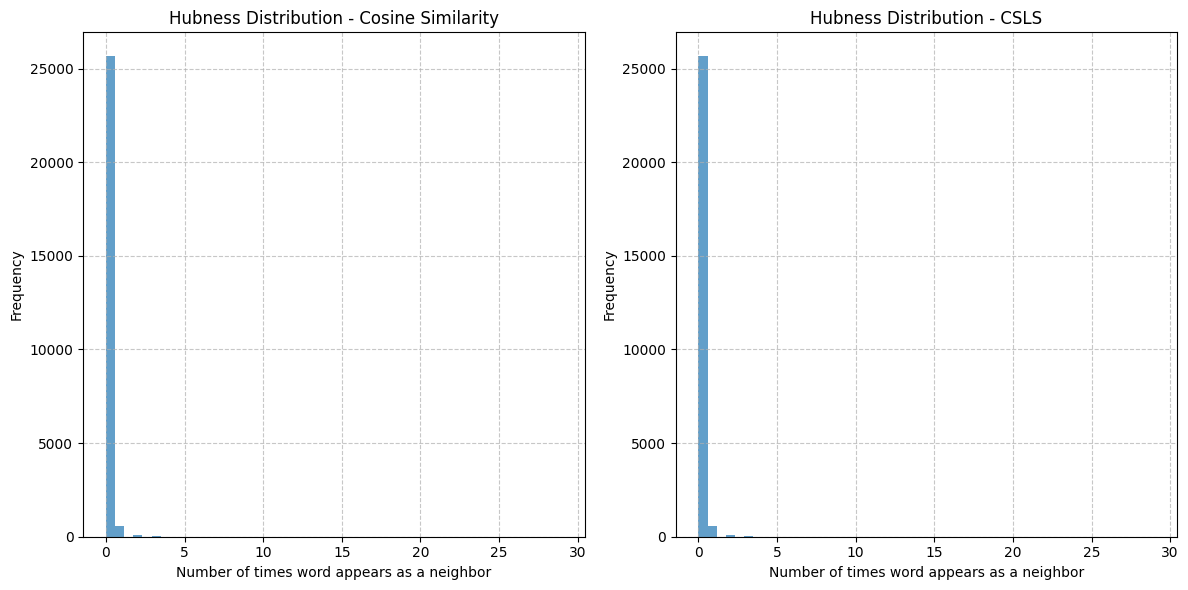

In [10]:
# 7. Analyzing hubness with CSLS

# 7.1 Measure hubness
def compute_hubness(src_vectors, tgt_vectors, W, n=10, method="cosine", sample_size=1000):
    """
    Compute the hubness score (N_n) for target words.
    N_n(y) is the number of times y appears in the n-nearest neighbors of all source words.
    """
    # Get a sample of source words for efficiency
    src_sample = list(src_vectors.keys())[:sample_size]
    tgt_words = list(tgt_vectors.keys())

    # Initialize hubness counts - only count for target words that are valid translations
    # This helps avoid the error when tgt_words is very large
    valid_tgt_words = set()
    for _, tgt in muse_dict:
        if tgt in tgt_vectors:
            valid_tgt_words.add(tgt)

    # If the valid target set is too small, use more target words
    if len(valid_tgt_words) < 100:
        valid_tgt_words = set(list(tgt_vectors.keys())[:1000])

    hubness_counts = {t: 0 for t in valid_tgt_words}

    # Ensure n is not too large
    n = min(n, len(valid_tgt_words))

    # Process each source word
    for src_word in tqdm(src_sample, desc="Computing hubness"):
        if method == "cosine":
            translations = translate_word(src_word, src_vectors, tgt_vectors, W, k=n)
        else:  # CSLS
            translations = translate_word_csls(src_word, src_vectors, tgt_vectors, W, k=n)

        for tgt_word, _ in translations:
            if tgt_word in hubness_counts:
                hubness_counts[tgt_word] += 1

    # Convert to pandas DataFrame for analysis
    hubness_df = pd.DataFrame({
        'word': list(hubness_counts.keys()),
        'count': list(hubness_counts.values())
    })

    return hubness_df

# Compute hubness for both methods with smaller sample size
print("\n=== Analyzing Hubness ===")
hubness_cosine = compute_hubness(en_vectors, hi_vectors, W, method="cosine", sample_size=500, n=5)
hubness_csls = compute_hubness(en_vectors, hi_vectors, W, method="csls", sample_size=500, n=5)

# Sort by count and get top hubs
top_hubs_cosine = hubness_cosine.sort_values('count', ascending=False).head(10)
top_hubs_csls = hubness_csls.sort_values('count', ascending=False).head(10)

print("\nTop 20 hubs with standard cosine similarity:")
print(top_hubs_cosine)

print("\nTop 20 hubs with CSLS:")
print(top_hubs_csls)

# Compare hubness distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(hubness_cosine['count'], bins=50, alpha=0.7)
plt.title('Hubness Distribution - Cosine Similarity')
plt.xlabel('Number of times word appears as a neighbor')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.hist(hubness_csls['count'], bins=50, alpha=0.7)
plt.title('Hubness Distribution - CSLS')
plt.xlabel('Number of times word appears as a neighbor')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('hubness_comparison.png')
plt.show()
